# Correlation Study Notebook

## Objectives

* Answer business requirement 1: 
  * The client is interested in discovering how the house attributes correlate with the sale price.

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv

## Outputs

* Generate code that answers business requirement 1 and can be used to build Streamlit App

## Conclusions

* Higher values of 1stFlrSF, garage area, GrLivArea, MasVnrArea and TotalBsmtSF are associated with higher sale price.
* Houses with recently built garages or recently added remods have higher prices than those of earlier ones.  
* Higher Overall quality indicates higher sale prices but kitchen quality does not show clear pattern. 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

# Load Data

In [ ]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv")
df.head(5)

# Data Exploration

We start with data profiling report so that we get more familiar with the content of the dataset. We check variable type and distribution, missing levels and how each variable may related to our target.
* We import pandas_profiling library and generate a profile report of our data
* Nine features have missing values.
* EnclosedPorch and WoodDeckSF have 90.7% and 89.4% missing values respectively.

In [ ]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

---

## Correlation and PPS Analysis

Our dataset has four categorical variables that are of object data type. So we need to encode them so that we can use them to calculate correlation coefficients.

In [23]:
import numpy as np
import ppscore as pps
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    if df.name == "corr_spearman":
      plt.savefig(f'docs/heatmap_corr_spearman.png', bbox_inches='tight')
    else:
      plt.savefig(f'docs/heatmap_corr_pearson.png', bbox_inches='tight')
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.savefig(f'docs/heatmap_pps.png', bbox_inches='tight')
      plt.show()


def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_spearman.name = 'corr_spearman'
  df_corr_pearson = df.corr(method="pearson")
  df_corr_pearson.name = 'corr_pearson'

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi-colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [24]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  420.0  0.053  0.094  0.0  0.0  0.0  0.067  0.579




* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



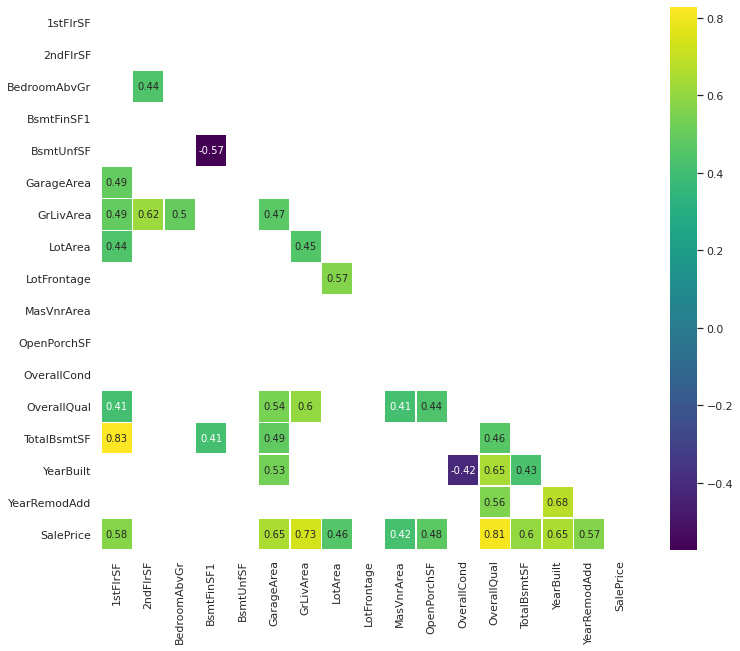



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



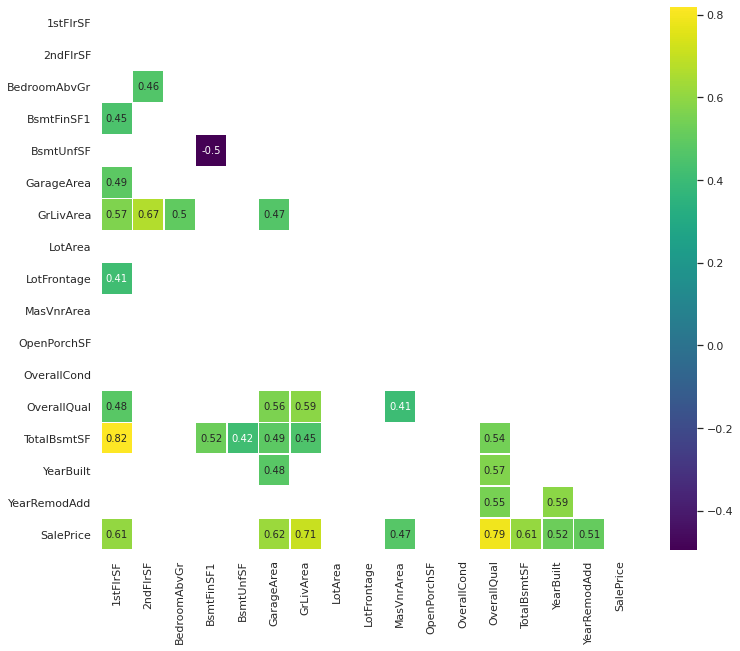



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



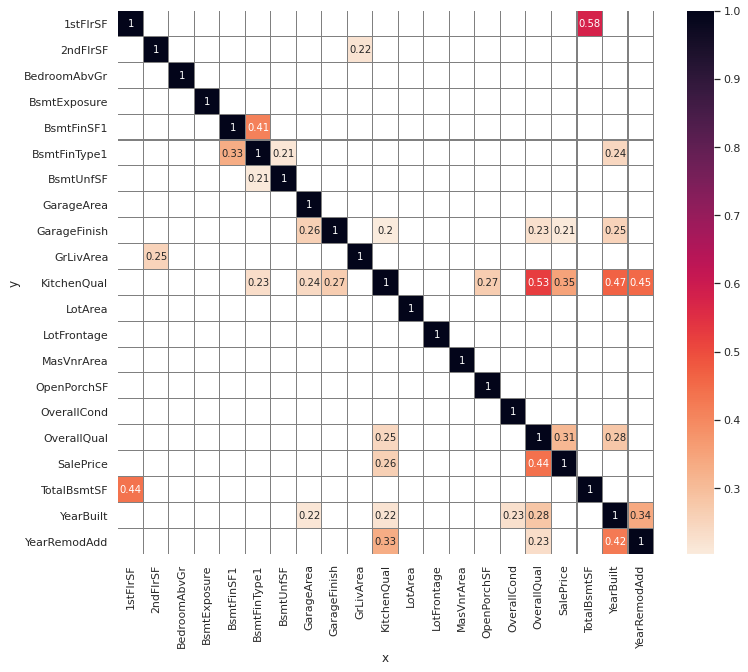

In [25]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

In [ ]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)
print(df_ohe.shape)
df_ohe.head(5)

In [ ]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(15)
corr_spearman

In [ ]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(15)
corr_pearson

In [ ]:
top_n = 10
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

Based on the correlation study results, we will focus on the following variables and their relationship to house sale prices.
* 1stFlrSF
* GarageArea
* GrLivArea
* KitchenQual
* MasVnrArea
* OpenPorchSF
* OverallQual
* TotalBsmtSF
* YearBuilt
* YearRemodAdd

In [ ]:
vars_to_study = ['1stFlrSF', 'GarageArea', 'GrLivArea', 'KitchenQual', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']
vars_to_study

# EDA on selected variables

In [ ]:
df_eda = df.filter(vars_to_study + ['SalePrice'])
df_eda.head()

## Target Analysis
### Distribution of Sales Price

We plot the distribution of sale price in relation to both numerical and categorical features

In [ ]:
sns.set_style('whitegrid')

time = ['YearBuilt', 'YearRemodAdd']

def plot_scatter(df, col, target_var):

  plt.figure(figsize=(12, 5))
  sns.scatterplot(data=df, x=col, y=target_var)
  plt.title(f"{col}", fontsize=20)        
  plt.show()

def plot_line(df, col, target_var):

  plt.figure(figsize=(12, 5))
  sns.lineplot(data=df, x=col, y=target_var)
  plt.title(f"{col}", fontsize=20)        
  plt.show()

def plot_box(df, col, target_var):
  plt.figure(figsize=(8, 5))
  sns.boxplot(data=df, x=col, y=target_var) 
  plt.title(f"{col}", fontsize=20)
  plt.show()


target_var = 'SalePrice'
for col in vars_to_study:
  if len(df_eda[col].unique()) <= 10:
    plot_box(df_eda, col, target_var)
    print("\n\n")
  else:
    if col in time:
      plot_line(df_eda, col, target_var)
      print("\n\n")
    else:
      plot_scatter(df_eda, col, target_var)
      print("\n\n")

---

# Conclusions and Next steps

We make the following observations from both the correlation analysis and the plots.
* Higher values of 1stFlrSF, garage area, GrLivArea, MasVnrArea and TotalBsmtSF are associated with higher sale price.
* Houses with recently added remods have higher prices than those of earlier ones.  
* Higher Overall quality indicates higher sale prices but kitchen quality does not show clear pattern. 